In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

import torch
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from CapsuleNet import CapsuleNetwork, CapsuleLoss, display_images
from utils import DICOMCoarseDataset, display_data_loader_batch

In [2]:
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 50
image_size = 128
classes = ["nodule", "non-nodule"]
train_ratio = 0.8

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

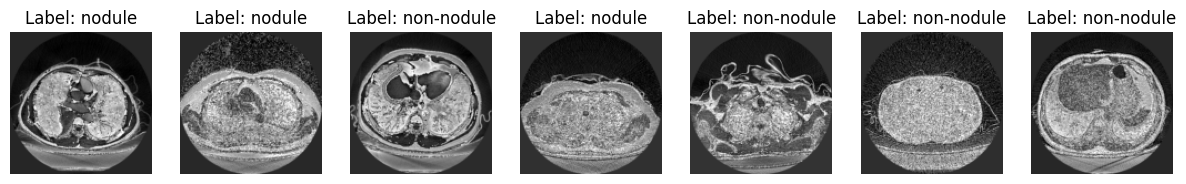

In [3]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),          # Random rotation up to 15 degrees
    transforms.RandomHorizontalFlip(),              # Random horizontal flip
    transforms.RandomVerticalFlip(),                # Random vertical flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transform
])

dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "nodule"))), classes=["nodule", "non-nodule"], transform=transform)
dataset.visualize_images(num_images=7)

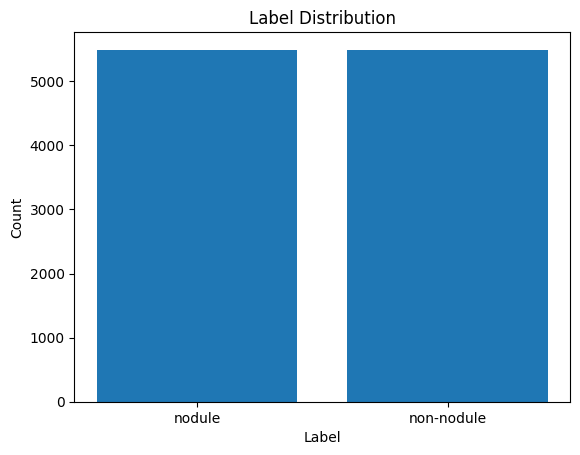

In [4]:
dataset.display_label_distribution()

In [ ]:
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataset.dataset.transform = train_transforms
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

display_data_loader_batch(train_loader, classes)

TypeError: display_data_loader_batch() missing 1 required positional argument: 'classes'

In [7]:
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)
print(capsule_net)

if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=16384, bias=True)
      (5): Sigmoid()
    )
  )
)


In [8]:
criterion = CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

In [9]:
n_epochs = 5
losses = capsule_net.train_model(train_loader, criterion, optimizer, n_epochs, print_every=1)

Epoch: 1 	Training Loss: 15.28797436
Epoch: 1 	Training Loss: 7.48442841
Epoch: 1 	Training Loss: 7.35472393
Epoch: 1 	Training Loss: 7.00133657
Epoch: 1 	Training Loss: 6.75767994
Epoch: 1 	Training Loss: 6.34591436
Epoch: 1 	Training Loss: 5.91838741
Epoch: 1 	Training Loss: 5.84579372
Epoch: 1 	Training Loss: 5.22604799
Epoch: 1 	Training Loss: 4.75702429
Epoch: 1 	Training Loss: 4.45365810
Epoch: 1 	Training Loss: 4.17800140
Epoch: 1 	Training Loss: 3.97342515
Epoch: 1 	Training Loss: 3.67145014
Epoch: 1 	Training Loss: 3.34557009
Epoch: 1 	Training Loss: 3.39893556
Epoch: 1 	Training Loss: 3.23227525
Epoch: 1 	Training Loss: 3.12282705
Epoch: 1 	Training Loss: 3.09104943
Epoch: 1 	Training Loss: 3.05239582
Epoch: 1 	Training Loss: 3.06820893
Epoch: 1 	Training Loss: 3.01981521
Epoch: 1 	Training Loss: 3.00812578
Epoch: 1 	Training Loss: 2.92679548
Epoch: 1 	Training Loss: 2.80283856
Epoch: 1 	Training Loss: 2.90280199
Epoch: 1 	Training Loss: 2.92183280
Epoch: 1 	Training Loss: 3.

Test Loss: 2.43770984

Test Accuracy of     0: 80% (905/1125)
Test Accuracy of     1: 87% (942/1073)

Test Accuracy (Overall): 84% (1847/2198)


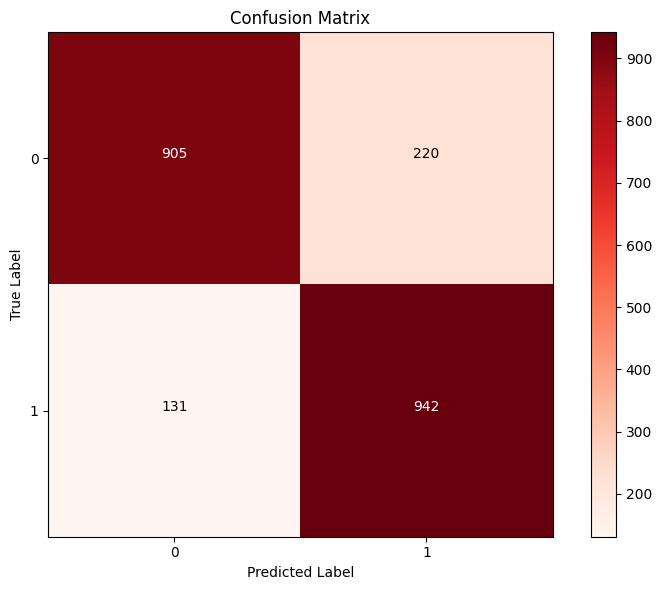

In [10]:
caps_outputs, images, reconstructions = capsule_net.test_model(criterion, test_loader)

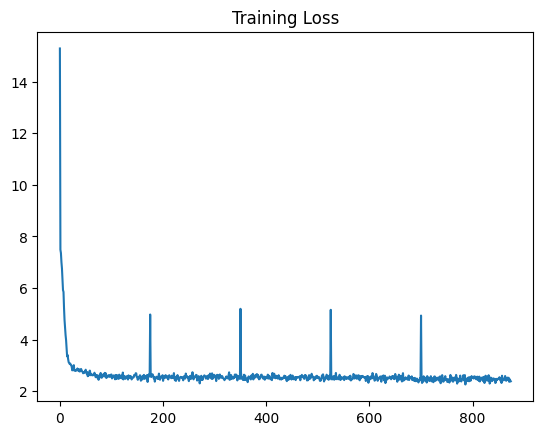

In [11]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

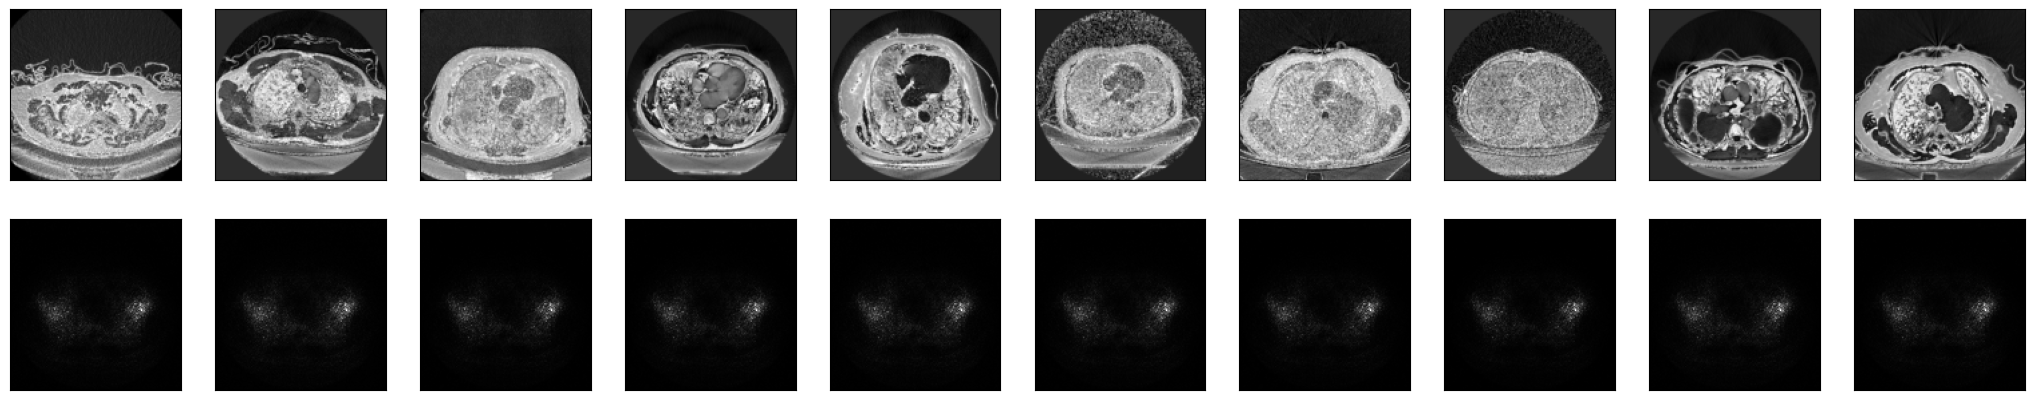

In [12]:
display_images(images, reconstructions)